# Machine Learning Project - MA Reviews Prediction

## Overview & Objective

  The dataset contains data collected from the https://www.metal-archives.com/, which is the 'Wikipedia' of metal music. Metal heads use this site to discover band information, ask for recommendations and write their reviews upon the albums.

  This particular dataset collects all the bands and albums info from the 'Death Metal' genre. 3 tables are included: bands table, albums table and reviews table. In all there are over 20000 valid reviews.

  The goal of this project is to use the given tables to predict the review score for each albums.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,precision_score,accuracy_score,f1_score

%matplotlib inline

In [89]:
albums = pd.read_csv('albums.csv')
bands = pd.read_csv('bands.csv')
reviews = pd.read_csv('reviews.csv')

In [145]:
country_list = list(bands['country'].value_counts().head().index)
bands['country']=bands['country'].apply(lambda x: x if x in country_list else 'Other')

In [90]:
albums.drop(columns='id',inplace=True)
reviews.drop(columns='id',inplace=True)

In [91]:
data = reviews.merge(albums,how='left',left_on='album',right_index=True).merge(bands,how='left',left_on='band',right_on='id')

In [92]:
data.rename(columns={'title_x':'review_title','title_y':'album_title','name':'band_name'},inplace=True)
data.drop(columns='id',inplace=True)

In [82]:
data.isnull().sum()

album              0
review_title       0
score              0
content            0
band               0
album_title        0
year               0
band_name          0
country            0
status             0
formed_in        435
genre              0
theme           2867
active           373
dtype: int64

In [80]:
data.head()

,album,review_title,score,content,band,album_title,year,band_name,country,status,formed_in,genre,theme,active
0,4,The Killer Count Just Keeps Rising,0.88,When I first threw this on I really didnt know...,7,Génesis & horror,2002,1917,Argentina,Active,1994.0,Death Metal,Dark Philosophical Poetry| Art| Religion| Psyc...,1994-present
1,5,A gem of heterogeneous death metal...,0.96,Several years ago I bought from a band member|...,7,Vision,2004,1917,Argentina,Active,1994.0,Death Metal,Dark Philosophical Poetry| Art| Religion| Psyc...,1994-present
2,8,Fantasic| if mostly for its influences,0.83,What a wonderful release this is. ‘Vox Fatum’ ...,7,Brutal Miserable Drama,2010,1917,Argentina,Active,1994.0,Death Metal,Dark Philosophical Poetry| Art| Religion| Psyc...,1994-present
3,45,A rare| lost hidden gem,0.80,Picture this: crushing| brutal death metal| wi...,43,Virtus Diaboli,2013,Abdicated,Brazil,Active,2009.0,Death Metal,Evil| Anti-Christianity| Satanism,2009-present
4,54,Pure| but flayed and covered in soot,0.92,Abhordium's When Depravity Incarnates is an ex...,60,You Only Die Once,2015,Abhorrent Aggression,United States,Split-up,2012.0,Death Metal,NaN,2012-2015


## Data Cleaning

- Original table has so many sub-genres, extract the main stream genres and convert rest as 'Other'
- Convert 'status' to 'active' and 'non-active'
- Extract the 5 most frequent countries and convert rest as 'Other'
- Convert 'year' to categorical features
- There are NaN values in 'formed_in' column, use the first album year as formed year
- For active bands, use 2019 as end year, for non-active bands, use split-up year as end year

In [93]:
genre_list = ['Doom','Progressive','Technical','Black','Melodic','Thrash','Brutal']

In [94]:
for i in genre_list:
    data['genre'] = data.apply(lambda x: f'{i}/Death Metal' if i in x['genre'] else x['genre'],axis=1)

In [95]:
data['genre'] = \
data.apply(lambda x: 'Other Genre' if x['genre'] not in ['Death Metal','Doom/Death Metal','Progressive Death Metal',
                                                     'Technical Death Metal','Black/Death Metal','Melodic Death Metal',
                                                     'Thrash/Death Metal','Symphonic Death Metal','Brutal Death Metal'
                                                     ] else x['genre'],axis=1)

In [96]:
data['active_status'] = data['status'].apply(lambda x:'Non-Active' if x!='Active' else x)

In [97]:
country_list = list(data['country'].value_counts().head().index)
data['country']=data['country'].apply(lambda x: x if x in country_list else 'Other')

In [98]:
data['theme'] = data['theme'].apply(lambda x:str(x).replace('|',','))
data['review_title'] = data['review_title'].apply(lambda x:str(x).replace('|',','))
data['content'] = data['content'].apply(lambda x:str(x).replace('|',','))

In [99]:
def cate_year(x):
    if 1995>=x>=1985:
        return '1985-1995'
    elif 2005>=x>1995:
        return '1995-2005'
    else:
        return '2005-Now'
    
data['year_cate'] = data['year'].apply(cate_year)

In [100]:
data['ended_in'] = data.apply(lambda x:str(x['active']).split('|')[-1].split('-')[-1]\
                   if x['status']=='Split-up' else '2019',axis=1)
data['ended_in'] = data['ended_in'].str.replace('?','2019').replace('nan','2019')
data['ended_in'] = data['ended_in'].apply(lambda x: int(x[:4]) if 'as' in x else int(x))

In [101]:
data = data.merge(
    data[data['formed_in'].isnull()].groupby('band').agg({'year':'min'})
    .reset_index().rename(columns={'year':'first_album_year'}),how='left',left_on='band',right_on='band')

In [102]:
data['formed_in'] = data.apply(lambda x:int(x['first_album_year']) if str(x['first_album_year'])!='nan' 
                               else int(x['formed_in']),axis=1)
data.drop(columns='first_album_year',inplace=True)

## Data Exploration

In [83]:
import plotly.graph_objs as go
import plotly.offline as py

py.init_notebook_mode(connected=True)

In [116]:
#Death metal was growing starting from 1985
data_plot = go.Bar(
    x=data['year'].value_counts().sort_index().head(10).index,
    y=data['year'].value_counts().sort_index().head(10).values,
    text=data['year'].value_counts().sort_index().head(10).values,
    textposition='outside'
)

layout = go.Layout(
    title='Albums Released by Year - Golden Years of Death Metal',
    xaxis=dict(title='Year',
              tickmode = 'linear',
              tick0 = 1985,
              dtick = 1),
    yaxis={'title':'Album Count'}
)

fig = go.Figure(data=data_plot, layout=layout)

py.iplot(fig)

In [115]:
data_plot = go.Pie(labels=data['status'].value_counts().index,
                   values=data['status'].value_counts(),
                   hoverinfo='label+percent',
                   text=data['status'].value_counts().index
),
layout = go.Layout(title='Status',     
                    hovermode='closest'
)
    
fig = go.Figure(data=data_plot, layout=layout)
py.iplot(fig)

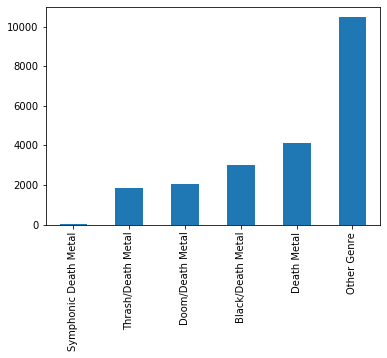

In [19]:
#Genre count
data['genre'].value_counts().sort_values().plot(kind='bar');

In [152]:
#Country count
data_plot = go.Bar(
    x=bands['country'].value_counts().sort_values().head(5).index,
    y=bands['country'].value_counts().sort_values().head(5).values,
    text=bands['country'].value_counts().sort_values().head(5).values,
    textposition='outside'
)

layout = go.Layout(
    title='Bands by Country',
    xaxis=dict(title='Country'),
    yaxis={'title':'Band Count'}
)

fig = go.Figure(data=data_plot, layout=layout)

py.iplot(fig)

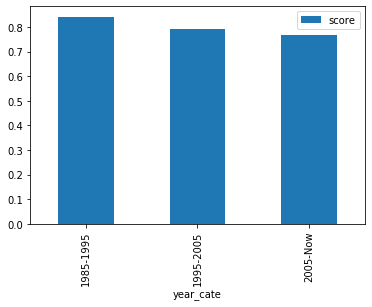

In [21]:
#Average score for each time period
data.groupby('year_cate').agg({'score':'mean'}).plot(kind='bar');

In [188]:
data

,album,review_title,score,content,band,album_title,year,band_name,country,status,formed_in,genre,theme,active,active_status,year_cate,ended_in
0,4,The Killer Count Just Keeps Rising,0.88,When I first threw this on I really didnt know...,7,Génesis & horror,2002,1917,Other,Active,1994,Death Metal,"Dark Philosophical Poetry, Art, Religion, Psyc...",1994-present,Active,1995-2005,2019
1,5,A gem of heterogeneous death metal...,0.96,"Several years ago I bought from a band member,...",7,Vision,2004,1917,Other,Active,1994,Death Metal,"Dark Philosophical Poetry, Art, Religion, Psyc...",1994-present,Active,1995-2005,2019
2,8,"Fantasic, if mostly for its influences",0.83,What a wonderful release this is. ‘Vox Fatum’ ...,7,Brutal Miserable Drama,2010,1917,Other,Active,1994,Death Metal,"Dark Philosophical Poetry, Art, Religion, Psyc...",1994-present,Active,2005-Now,2019
3,45,"A rare, lost hidden gem",0.80,"Picture this: crushing, brutal death metal, wi...",43,Virtus Diaboli,2013,Abdicated,Other,Active,2009,Death Metal,"Evil, Anti-Christianity, Satanism",2009-present,Active,2005-Now,2019
4,54,"Pure, but flayed and covered in soot",0.92,Abhordium's When Depravity Incarnates is an ex...,60,You Only Die Once,2015,Abhorrent Aggression,United States,Split-up,2012,Death Metal,nan,2012-2015,Non-Active,2005-Now,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21505,28061,Delightful,0.89,"What can a man accomplish in two years? Well, ...",37723,Sapphiric,2006,Frozen Mist,United States,Active,2004,Black/Death Metal,"Darkness, Despair, Death, Horror, Pagan Ancestry",2004-2014| 2014-2016| 2016-present,Active,2005-Now,2019
21506,28065,Frozen Mist White Noise Paranormal,0.80,Every now and then I stumble upon a really coo...,37723,Anomalies of the Forest,2011,Frozen Mist,United States,Active,2004,Black/Death Metal,"Darkness, Despair, Death, Horror, Pagan Ancestry",2004-2014| 2014-2016| 2016-present,Active,2005-Now,2019
21507,28065,Terrifying experimental death metal,0.80,Crawling out from Montoursville Pennysylvania ...,37723,Anomalies of the Forest,2011,Frozen Mist,United States,Active,2004,Black/Death Metal,"Darkness, Despair, Death, Horror, Pagan Ancestry",2004-2014| 2014-2016| 2016-present,Active,2005-Now,2019
21508,28066,Frozen Mist Anomalies Of The Forest,0.80,Deep in the mountain forest of Pennsylvania lu...,37723,Mother Earth Pantheon,2012,Frozen Mist,United States,Active,2004,Black/Death Metal,"Darkness, Despair, Death, Horror, Pagan Ancestry",2004-2014| 2014-2016| 2016-present,Active,2005-Now,2019


In [198]:
data_plot = go.Histogram(
            x=data.groupby('band').agg({'score':'mean'}).reset_index()['score'],
            xbins=dict(
                      start=0,
                      end=1,
                      size=0.05),
                      autobinx=False
)


layout = go.Layout(
    title='Score Distribution',
    xaxis=dict(title='Score')    
)

fig = go.Figure(data=data_plot, layout=layout)

py.iplot(fig)

In [162]:
data_plot = go.Bar(
    x=data.groupby('genre').agg({'score':'mean'})['score'].index,
    y=data.groupby('genre').agg({'score':'mean'})['score'].values,
    text=data.groupby('genre').agg({'score':'mean'}).round(3)['score'].values,
    textposition='outside'
)

layout = go.Layout(
    title='Avg Score by Sub-Genre',
    xaxis=dict(title='Sub-Genre'),
    yaxis={'title':'Score'}
)

fig = go.Figure(data=data_plot, layout=layout)

py.iplot(fig)

## Best death metal band ever and forever

### R.I.P 'Evil Chuck' Schuldiner

In [23]:
#Table for album and review count for each band
review_album_cnt = pd.DataFrame(albums['band'].value_counts()).reset_index().rename(columns={'index':'band_id','band':'album_cnt'})\
.merge(bands[['id','name']],left_on='band_id',right_on='id').drop(columns='id')\
.merge(pd.DataFrame(data['band'].value_counts()).rename(columns={'band':'review_cnt'}),
       left_on='band_id',right_index=True,how='left')

In [25]:
#Best of the best:
#Highest average score for each band with over 6 albums and 50 reviews
data.groupby('band').agg({'score':'mean'}).merge(
    review_album_cnt[(review_album_cnt['album_cnt']>6) & (review_album_cnt['review_cnt']>50)],
    left_index=True,right_on='band_id',how='right')\
    .sort_values(by='score',ascending=False).head(1)

,score,band_id,album_cnt,name,review_cnt
217,0.893806,35522,7,Death,134.0


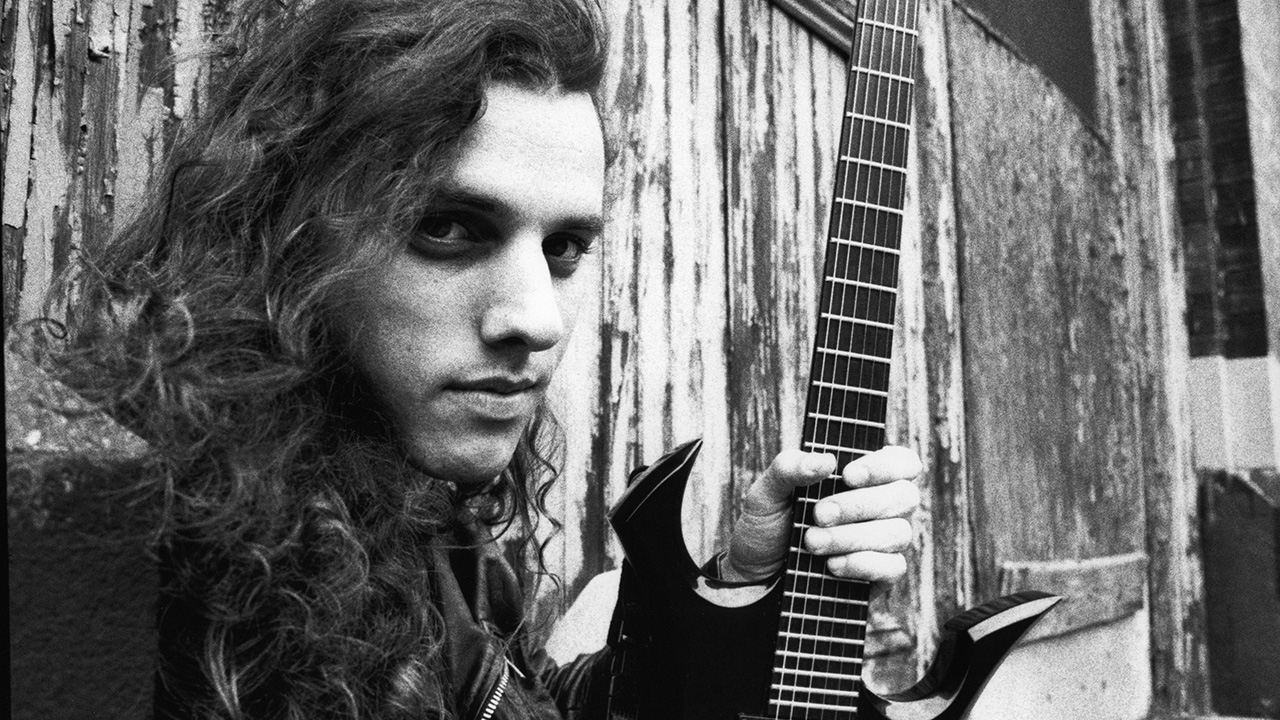

## Feature Engineering

- NLP process for review title and review content


In [26]:
#Tokenizing the content and title
data['nlp_title'] = data['review_title'].str.lower().replace('\W+', ' ').apply(nltk.word_tokenize)
data['nlp_content'] = data['content'].str.lower().replace('\W+', ' ').apply(nltk.word_tokenize)

In [27]:
#Try both stemming and lemmatizing
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

In [28]:
data['nlp_content_stem'] = data['nlp_content'].apply(lambda x:[stemmer.stem(word) for word in x])
data['nlp_title_stem'] = data['nlp_title'].apply(lambda x:[stemmer.stem(word) for word in x])

In [29]:
data['nlp_content_lemm'] = data['nlp_content'].apply(lambda x:[lemmatizer.lemmatize(word) for word in x])
data['nlp_title_lemm'] = data['nlp_title'].apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

In [30]:
data['nlp_content'] = data['nlp_content'].apply(lambda x:' '.join(x))
data['nlp_title'] = data['nlp_title'].apply(lambda x:' '.join(x))
data['nlp_content_stem'] = data['nlp_content_stem'].apply(lambda x:' '.join(x))
data['nlp_title_stem'] = data['nlp_title_stem'].apply(lambda x:' '.join(x))
data['nlp_content_lemm'] = data['nlp_content_lemm'].apply(lambda x:' '.join(x))
data['nlp_title_lemm'] = data['nlp_title_lemm'].apply(lambda x:' '.join(x))

In [31]:
#Add my stop words
my_stop_words=['death','metal','guitar','drum','riff','riffs','bass','album','band','genre']

In [32]:
#Vectorizing the text
tfidf = TfidfVectorizer(max_features=500,
                        ngram_range=(1,2), 
                        stop_words=stopwords.words('english') + my_stop_words
                        )

In [33]:
tfidf_matrix = pd.DataFrame(tfidf.fit_transform(data['nlp_title_stem'].map(str)+' '+ data['nlp_content_stem']).toarray(),
                         columns=tfidf.vocabulary_)

- Sentiment analysis
- Need to manually remove some 'negative' words, since for death metal some negative words are actually positive like 'brutal'

In [34]:
sid = SentimentIntensityAnalyzer()

In [35]:
neutral = ['aggressive','aggressively','aggressivity','agony','amorphous','anger','angry','anti','assault','attack','attacked',
        'badass','bastard','battle','battlefield','betray','betrayal','brutal','brutality','catastrophic',
       'chaos','chaotic','corpse','crazy','cruel','crueler','cruelty','crush','crushed','cynic','cynical','dangerous',
       'darkness','darkest','death','depress','depressed','depression','depressive','despair','despaired','destroy',
       'destroyed','destruction','destructions','destructive','devastating','devil','devils','doom','evil','fear',
       'fearful','fearfully','freaking','furious','furiously','harsh','hate','hatred','hell','hellish','insane','kill',
       'killer','maniac','offensive','offensively','outrage','outrageous','rage','raged','rages','revenge','revenged','savage',
       'savages','scary','slam','sin','sinister','terror','terrors','war','wars','wicked']

In [36]:
for word in neutral:
    sid.lexicon.pop(word)

In [37]:
data['sentiment'] = data['content'].apply(lambda x:sid.polarity_scores(x)['compound'])

- Get active years for each band
- Define style: released before 2000 -> old school, after 2000 -> new style
- Album release time: first 1/3 of the band career -> early album, 2/3 of the career -> mid album, last 1/3 -> late album
- Convert score to 3 labels

In [38]:
data['active_years'] = data['ended_in']-data['formed_in']

In [39]:
data['old_new'] = data['formed_in'].apply(lambda x:'old_school' if x<2000 else 'new_style')

In [40]:
def album_time(x):
    if x['year']-x['formed_in']<=x['active_years']*0.4:
        return 'early_album'
    elif x['active_years']*0.4<x['year']-x['formed_in']<=x['active_years']*0.7:
        return 'mid_album'
    else:
        return 'late_album'
data['time_of_career'] = data.apply(album_time,axis=1)

In [41]:
def score_lvl(x):
    if x>0.85:
        return 'Must Listen'
    elif 0.85>=x>0.6:
        return 'Average Metal'
    else:
        return 'Garbage'

In [42]:
data['label'] = data['score'].apply(score_lvl)

In [43]:
data

,album,review_title,score,content,band,album_title,year,band_name,country,status,...,nlp_content,nlp_content_stem,nlp_title_stem,nlp_content_lemm,nlp_title_lemm,sentiment,active_years,old_new,time_of_career,label
0,4,The Killer Count Just Keeps Rising,0.88,When I first threw this on I really didnt know...,7,Génesis & horror,2002,1917,Other,Active,...,when i first threw this on i really didnt know...,when i first threw thi on i realli didnt know ...,the killer count just keep rise,when i first threw this on i really didnt know...,the killer count just keep rising,0.9936,25,old_school,early_album,Must Listen
1,5,A gem of heterogeneous death metal...,0.96,"Several years ago I bought from a band member,...",7,Vision,2004,1917,Other,Active,...,several years ago i bought from a band member ...,"sever year ago i bought from a band member , t...",a gem of heterogen death metal ...,"several year ago i bought from a band member ,...",a gem of heterogeneous death metal ...,0.9824,25,old_school,early_album,Must Listen
2,8,"Fantasic, if mostly for its influences",0.83,What a wonderful release this is. ‘Vox Fatum’ ...,7,Brutal Miserable Drama,2010,1917,Other,Active,...,what a wonderful release this is . ‘ vox fatum...,what a wonder releas thi is . ‘ vox fatum ’ is...,"fantas , if mostli for it influenc",what a wonderful release this is . ‘ vox fatum...,"fantasic , if mostly for it influence",0.9957,25,old_school,mid_album,Average Metal
3,45,"A rare, lost hidden gem",0.80,"Picture this: crushing, brutal death metal, wi...",43,Virtus Diaboli,2013,Abdicated,Other,Active,...,"picture this : crushing , brutal death metal ,...","pictur thi : crush , brutal death metal , with...","a rare , lost hidden gem","picture this : crushing , brutal death metal ,...","a rare , lost hidden gem",-0.4926,10,new_style,early_album,Average Metal
4,54,"Pure, but flayed and covered in soot",0.92,Abhordium's When Depravity Incarnates is an ex...,60,You Only Die Once,2015,Abhorrent Aggression,United States,Split-up,...,abhordium 's when depravity incarnates is an e...,abhordium 's when deprav incarn is an extrem p...,"pure , but flay and cover in soot",abhordium 's when depravity incarnates is an e...,"pure , but flayed and covered in soot",0.9989,3,new_style,late_album,Must Listen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21505,28061,Delightful,0.89,"What can a man accomplish in two years? Well, ...",37723,Sapphiric,2006,Frozen Mist,United States,Active,...,what can a man accomplish in two years ? well ...,"what can a man accomplish in two year ? well ,...",delight,"what can a man accomplish in two year ? well ,...",delightful,0.8408,15,new_style,early_album,Must Listen
21506,28065,Frozen Mist White Noise Paranormal,0.80,Every now and then I stumble upon a really coo...,37723,Anomalies of the Forest,2011,Frozen Mist,United States,Active,...,every now and then i stumble upon a really coo...,everi now and then i stumbl upon a realli cool...,frozen mist white nois paranorm,every now and then i stumble upon a really coo...,frozen mist white noise paranormal,0.9810,15,new_style,mid_album,Average Metal
21507,28065,Terrifying experimental death metal,0.80,Crawling out from Montoursville Pennysylvania ...,37723,Anomalies of the Forest,2011,Frozen Mist,United States,Active,...,crawling out from montoursville pennysylvania ...,crawl out from montoursvil pennysylvania usa f...,terrifi experiment death metal,crawling out from montoursville pennysylvania ...,terrifying experimental death metal,0.9803,15,new_style,mid_album,Average Metal
21508,28066,Frozen Mist Anomalies Of The Forest,0.80,Deep in the mountain forest of Pennsylvania lu...,37723,Mother Earth Pantheon,2012,Frozen Mist,United States,Active,...,deep in the mountain forest of pennsylvania lu...,deep in the mountain forest of pennsylvania lu...,frozen mist anomali of the forest,deep in the mountain forest of pennsylvania lu...,frozen mist anomaly of the forest,-0.4188,15,ne

## Models and Predictions

- Try GridSearch with LogisticRegression and RandomForest
- KFold validation for every model

In [44]:
data_test = data[['country','active_status','genre','year_cate','sentiment','active_years','old_new','time_of_career']]

In [45]:
test = pd.get_dummies(data_test)

In [46]:
X=pd.concat([tfidf_matrix,test],axis=1)
y=data['label']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### LogisticRegression

In [48]:
lr_clf = LogisticRegression(C = 0.5, penalty='l2',multi_class='ovr',solver='liblinear')

In [49]:
lr_clf.fit(X_train,y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_pred_lr = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred_lr))

               precision    recall  f1-score   support

Average Metal       0.64      0.67      0.66      2667
      Garbage       0.70      0.46      0.55       952
  Must Listen       0.72      0.78      0.75      2834

     accuracy                           0.69      6453
    macro avg       0.69      0.64      0.65      6453
 weighted avg       0.69      0.69      0.68      6453



In [51]:
parameters = {'C':[0.1,0.5,1.0], 'penalty':['l1','l2']}

In [52]:
lr_CV = GridSearchCV(estimator=lr_clf, param_grid=parameters, cv= 5)

In [53]:
lr_CV.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=0.5, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1.0], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [54]:
lr_CV.cv_results_

{'mean_fit_time': array([1.19126081, 1.56625524, 5.73989649, 2.00652924, 7.46617279,
        2.41439843]),
 'std_fit_time': array([0.11074475, 0.06477378, 0.7677845 , 0.02038265, 0.84835911,
        0.05138734]),
 'mean_score_time': array([0.01163044, 0.01848345, 0.01060982, 0.01884093, 0.01118178,
        0.01901503]),
 'std_score_time': array([0.00043423, 0.00024131, 0.00078129, 0.00048132, 0.00013753,
        0.0011453 ]),
 'param_C': masked_array(data=[0.1, 0.1, 0.5, 0.5, 1.0, 1.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1, 'penalty': 'l1'},
  {'C': 0.1, 'penalty': 'l2'},
  {'C': 0.5, 'penalty': 'l1'},
  {'C': 0.5, 'penalty': 'l2'},
  {'C': 1.0, 'penalty': 'l1'},
  {'C': 1.0, 'penalty': 'l2'}],
 'split

#### DecisionTree

In [55]:
dt_clf = DecisionTreeClassifier(criterion='entropy')

In [56]:
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [57]:
y_pred_dt = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred_dt))

               precision    recall  f1-score   support

Average Metal       0.50      0.51      0.50      2667
      Garbage       0.33      0.35      0.34       952
  Must Listen       0.59      0.57      0.58      2834

     accuracy                           0.51      6453
    macro avg       0.47      0.47      0.47      6453
 weighted avg       0.51      0.51      0.51      6453



#### RandomForest

In [58]:
rf_clf = RandomForestClassifier(criterion='entropy',max_depth=100,n_estimators=100,n_jobs=-1)

In [59]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [60]:
y_pred_rf = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

               precision    recall  f1-score   support

Average Metal       0.58      0.67      0.62      2667
      Garbage       0.84      0.20      0.33       952
  Must Listen       0.68      0.75      0.71      2834

     accuracy                           0.64      6453
    macro avg       0.70      0.54      0.55      6453
 weighted avg       0.66      0.64      0.62      6453



In [61]:
parameters = {'criterion':['entropy', 'gini'], 'max_depth':[75,100],'n_estimators':[75,100]}

In [62]:
rf_CV = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv=5)

In [63]:
rf_CV.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=100,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                      

In [64]:
rf_CV.cv_results_

{'mean_fit_time': array([3.24439335, 4.02689967, 2.83343725, 3.70779905, 2.2296361 ,
        2.8933547 , 2.20210395, 2.8808352 ]),
 'std_fit_time': array([0.78524473, 0.53619432, 0.02026665, 0.05329094, 0.01578809,
        0.01227208, 0.01591209, 0.02086935]),
 'mean_score_time': array([0.13499479, 0.13144341, 0.13035793, 0.12856059, 0.12724681,
        0.12953906, 0.12902527, 0.13011279]),
 'std_score_time': array([0.00964147, 0.00318751, 0.00275847, 0.00354907, 0.00250043,
        0.0030931 , 0.00300434, 0.00334837]),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'gini',
                    'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[75, 75, 100, 100, 75, 75, 100, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'pa

#### XGBoost

In [65]:
xgb=XGBClassifier(max_depth=5,n_estimators=100,n_jobs=-1)

In [66]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [67]:
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

               precision    recall  f1-score   support

Average Metal       0.63      0.68      0.65      2667
      Garbage       0.71      0.41      0.52       952
  Must Listen       0.71      0.76      0.73      2834

     accuracy                           0.67      6453
    macro avg       0.68      0.62      0.64      6453
 weighted avg       0.68      0.67      0.67      6453



- KFold Validation


In [68]:
f1_score_train_all = []
accu_score_train_all = []
f1_score_cv_all = []
accu_score_cv_all = []

kf = KFold(n_splits=5,random_state=42,shuffle=True)

X=pd.concat([tfidf_matrix,test],axis=1)
y=data['label']

models = [LogisticRegression(C = 0.5, penalty='l2',multi_class='ovr',solver='liblinear'),
        DecisionTreeClassifier(criterion='gini',max_depth=100),
        RandomForestClassifier(criterion='gini',max_depth=100,n_estimators=100,n_jobs=-1),
        XGBClassifier(max_depth=5,n_estimators=100,n_jobs=-1)]


for i in range(len(models)):
    model = models[i]
    f1_score_cv = []
    accu_score_cv = []
    f1_score_train = []
    accu_score_train = []

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        f1_score_train.append(np.mean(f1_score(y_train,y_pred_train,average=None)))
        accu_score_train.append(np.mean(precision_score(y_train,y_pred_train,average=None)))
        f1_score_cv.append(np.mean(f1_score(y_test,y_pred,average=None)))
        accu_score_cv.append(np.mean(precision_score(y_test,y_pred,average=None)))

    f1_score_train_all.append(np.mean(f1_score_train))
    accu_score_train_all.append(np.mean(accu_score_train))
    f1_score_cv_all.append(np.mean(f1_score_cv))
    accu_score_cv_all.append(np.mean(accu_score_cv))
    print(models[i])
    print(f'Training f1 score is {np.mean(f1_score_train_all)}')
    print(f'Training precision score is {np.mean(accu_score_train_all)}')
    print(f'Cross-validation f1 score is {np.mean(f1_score_cv_all)}')
    print(f'Cross-validation precision score is {np.mean(accu_score_cv_all)}')

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Training f1 score is 0.6882645426572077
Training precision score is 0.7246493093469945
Cross-validation f1 score is 0.6665910530638948
Cross-validation precision score is 0.7036927571286276
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Training f1 score is 0.8441322713286039
Training precision score is 0.8623246

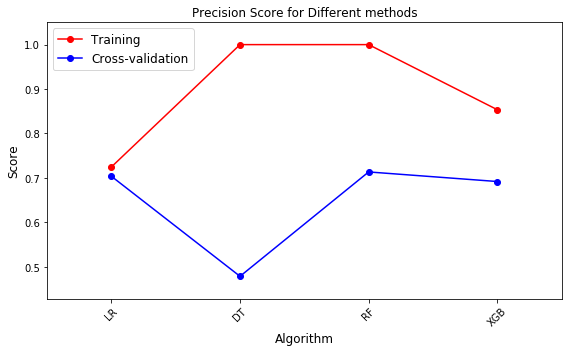

In [69]:
ymin = np.min(accu_score_cv_all)-0.05
ymax = np.max(accu_score_train_all)+0.05

x_ticks = ['LR','DT','RF','XGB']

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), accu_score_train_all, 'ro-', label = 'Training')
plt.plot(range(len(x_ticks)), accu_score_cv_all, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(
    x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Algorithm", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 3.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Precision Score for Different methods")

plt.tight_layout()